<h1>CS4618: Artificial Intelligence I</h1>
<h1>Neural Network Examples</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import Rescaling

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets.mnist import load_data

<h1>Preliminaries</h1>
<ul>
    <li>The code below reads the CorkA, CS1109 and Iris datasets from CSV files to Panda DataFrames, shuffles them, splits them 80% train and 20% test, and converts to numpy arrays.
    </li>
</ul>

In [3]:
# Cork Property Prices Dataset

# Use pandas to read the CSV file into a DataFrame
cork_df = pd.read_csv("../datasets/dataset_corkA.csv")

# Shuffle the dataset
cork_df = cork_df.sample(frac=1, random_state=2)
cork_df.reset_index(drop=True, inplace=True)

# Split off the test set: 20% of the dataset.
train_cork_df, test_cork_df = train_test_split(cork_df, train_size=0.8, random_state=2)

# The features 
cork_features = ["flarea", "bdrms", "bthrms"]

# Extract the features and convert to numpy array
train_cork_X = train_cork_df[cork_features].values
test_cork_X = test_cork_df[cork_features].values

# Target values, converted to a 1D numpy array
train_cork_y = train_cork_df["price"].values
test_cork_y = test_cork_df["price"].values

In [4]:
# CS1109 Dataset

# Use pandas to read the CSV file into a DataFrame
cs1109_df = pd.read_csv("../datasets/dataset_cs1109.csv")

# Shuffle the dataset
cs1109_df = cs1109_df.sample(frac=1, random_state=2)
cs1109_df.reset_index(drop=True, inplace=True)

# Split off the test set: 20% of the dataset.
train_cs1109_df, test_cs1109_df = train_test_split(cs1109_df, train_size=0.8, random_state=2)

# The features 
cs1109_features = ["lect", "lab", "cao"]

# Extract the features and convert to a numpy array
train_cs1109_X = train_cs1109_df[cs1109_features].values
test_cs1109_X = test_cs1109_df[cs1109_features].values

# Target values, encoded and converted to a 1D numpy array
label_encoder = LabelEncoder()
label_encoder.fit(cs1109_df["outcome"])
train_cs1109_y = label_encoder.transform(train_cs1109_df["outcome"])
test_cs1109_y = label_encoder.transform(test_cs1109_df["outcome"])

In [5]:
# Iris dataset

# Load the dataset (a dictionary) and get the features DataFrame and target values from the dictionary
iris = load_iris(as_frame=True)
iris_df = iris.data
iris_y = iris.target

# Shuffle the features and the target values in the same way
idx = np.random.permutation(iris_df.index)
iris_df.reindex(idx)
iris_y.reindex(idx)
iris_df.reset_index(drop=True, inplace=True)
iris_y.reset_index(drop=True, inplace=True)

# Split off the test set: 20% of the dataset.
train_iris_df, test_iris_df, train_iris_y, test_iris_y = train_test_split(iris_df, iris_y, train_size=0.8, 
                                                                              random_state=4)

# Convert to numpy arrays
train_iris_X = train_iris_df.values
train_iris_y = train_iris_y.values
test_iris_X = test_iris_df.values
test_iris_y = test_iris_y.values

<h1>Introduction</h1>
<ul>
    <li>We'll use layered, dense, feedforward neural networks for regression, binary classification
        and multi-class classification:
        <ul>
            <li>We'll use our three small datasets that, as we discussed before, contain <b>structured data</b> (sometimes
                called <b>tabular data</b>): not necessarily ideal for deep learning.</li>
            <li>We'll see one example that uses images.</li>
        </ul>
    </li>
    <li>This will illustrate some of the different activation functions we can use:
        <ul>
            <li>in the output layer: linear, sigmoid or softmax; and</li>
            <li>in the hidden layers: sigmoid or ReLU.</li>
        </ul>
    </li>
    <li>This will also introduce the Keras library.</li>
</ul>

<h1>The Keras library</h1>
<ul>
    <li>scikit-learn has very limited support for neural networks.</li>
    <li>There are now many software frameworks that do support tensor computation, neural neworks and deep learning 
         including in Python:
        <ul>
            <li>TensorFlow, PyTorch and JAX are the main ones.</li>
        </ul>
    </li>
    <li>We will use Keras, which is a high-level API, first released in 2015
        by Fran&ccedil;ois Chollet of Google (<a href="https://keras.io">https://keras.io</a>), which has done
        a lot to make Deep Learning accessible to people:
        <ul>
            <li>It is very high-level, making it easy to construct networks, fit models and make predictions.</li>
            <li>It is multi-backend, meaning it works atop of whichever framework you prefer (TensorFlow, PyTorch or JAX).</li>
            <li>The downside is it gives less fine-graned control than the backend framework itself. When fine-grained control is needed, you can mix in functions, methods and classes from the backend.</li>
            <li>This seems a suitable trade-off for us: our module is about AI, not the intricacies of
                TensorFlow, PyTorch or JAX.
            </li>
        </ul>
    </li>
</ul>

<h1>Keras concepts</h1>
<ul>
    <li><b>Layers</b> are the building blocks.
        <ul>
            <li>To begin with, we will use <b>dense layers</b>.</li>
            <li>The activation functions of <em>hidden layers</em> are open for you to choose, 
                e.g. sigmoid or ReLU.
            </li>
            <li>But the activation functions of <em>output layers</em> are determined by the task:
                <ul>
                    <li>Regression: linear activation function (default);</li>
                    <li>Binary classification: sigmoid activation function; and</li>
                    <li>Multiclass classification: softmax activation function.</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Layers are combined into <b>networks</b>:
        <ul>
            <li>Consecutive layers must be compatible: the shape of the input to one layer is the shape of 
                the output of the preceding layer.
            </li>
            <li>In early lectures, we only consider a stack of layers but Keras allows directed acyclic graphs 
                and, later, we will briefly discuss some examples that are not just stacks of layers.
            </li>
        </ul>
    </li>
    <li>Once the network is built, we <b>compile</b> it, specifying:
        <ul>
            <li>A <b>loss function</b>:
                <ul>
                    <li>Regression, e.g. mean-squared-error (<code>mse</code>);</li>
                    <li>Binary classification, e.g. (binary) cross-entropy (<code>binary_crossentropy</code>);</li>
                    <li>Multiclass classification, e.g. (categorical) cross-entropy 
                        (<code>sparse_categorical_crossentropy</code> if the labels are encoded as
                        integer labels
                        or <code>categorical_crossentropy</code> if the integer labels have also been one-hot
                        encoded).</li>
                </ul>
            </li>
            <li>An <b>optimizer</b>, such as SGD &mdash; but see below.</li>
            <li>A list of metrics to monitor during training and testing:
                <ul>
                    <li>Regression, e.g. mean-absolute-error (<code>mae</code>);</li>
                    <li>Classification, e.g. accuracy (<code>acc</code>).</li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

<h1>Keras optimizers</h1>
<ul>
    <li>We know about Gradient Descent: Batch, Mini-Batch, Stochastic.</li>
    <li>Without going into details, many other variants of Gradient Descent have been devised (e.g. RMSprop, Adam, Adagrad, &hellip;):
        <ul>
            <li>some may have better convergence behaviour in the case of local minima;</li>
            <li>some may converge more quickly.</li>
        </ul>
        although a disadvantage is that they typically introduce further hyperparameters
        (e.g. momentum) in addition to learning rate.
    </li>
    <li>We'll use RMSprop below.
        <ul>
            <li>Be aware, its default learning rate is 0.001. This is usually OK, but in some cases you may need  
                to change it.
            </li>
        </ul>
    </li>
    <li>Be aware too that there is an argument called <code>batch_size</code>. Assuming we set its value to                   somewhere between 1 and the size of the training set then we are getting Mini-Batch Gradient Descent.
    </li>
</ul>

In [6]:
# If using tensorflow as backed, you may get warnings that explain that tensorflow was 
# originally compiled on a different computer architecture from the one you are using. 
# This means its performance may not be optimal. The warning explains that, if you want 
# to optimize tensorflow for your architecture, then you need to rebuild (recompile)
# tensorflow from scratch. We won't do this!

<h1>A Neural Network for Regression</h1>
<ul>
    <li>For regression on structured/tabular data, we might use a network with the following architecture:
        <ul>
            <li>Input layer: one input per feature.</li>
            <li>Hidden layers: one or more hidden layers.
                <ul>
                    <li>Activation function for neurons in hidden layers can be the sigmoid function or ReLU.
                </ul>
            </li>
            <li>Output layer: just one output neuron (assuming we're predicting a single number per example).
                <ul>
                    <li>Activation function for the output neuron should be the <b>linear function</b>: 
                        $g(z) = z$
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>(There are also biases in each layer except the output layer &mdash; Keras will give us these 
        'for free'.)
    </li>
</ul>

<h2>Example: Cork Property Prices</h2>
<ul>
    <li>We don't want too many hidden layers, nor too many neurons in each hidden layer. Why?</li>
    <li>Let's start with this:
        <ul>
            <li>An input layer with three inputs ($\mathit{flarea}$, $\mathit{bdrms}$, 
                $\mathit{bthrms}$);
            </li>
            <li>Two hidden layers, with 64 neurons in each, and ReLU activation function;</li>
            <li>An output layer with a single neuron and linear activation function.</li>
        </ul>
    </li>
    <li>We need to scale the features (Why?) But, since we are now not using scikit-learn's <code>ColumnTransformer</code>s to create a preprocessor, we need to take care of the scaling. Two approaches are
        illustrated below.
    </li>
    <li>Our first approach is to write our own code to scale the data. Notice that the means and standard
        deviations that are computed from the training set are used to standardize both the training set and
        the test set, thus avoiding leakage.
    </li>
</ul>

In [7]:
means = train_cork_X.mean(axis=0)
st_devs = train_cork_X.std(axis=0)

train_cork_X -= means
train_cork_X /= st_devs

test_cork_X -= means
test_cork_X /= st_devs

In [8]:
inputs = Input(shape=(3,))
x = Dense(64, activation="relu")(inputs)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)
cork_model = Model(inputs, outputs)

cork_model.compile(optimizer=RMSprop(learning_rate=0.001), loss="mse", metrics=["mae"])

2023-07-14 11:04:01.163647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
cork_model.fit(train_cork_X, train_cork_y, epochs=40, batch_size=32, verbose=0)

In [10]:
test_loss, test_mae = cork_model.evaluate(test_cork_X, test_cork_y)
test_mae

3/3 [==============================] - 0s 3ms/step - loss: 15071.4570 - mae: 87.7902


87.79022979736328

<ul>
    <li>The disdavantage is the need to remember to run the preprocessing code.</li> 
    <li>The second approach is to use a layer in the neural network: <code>NormalizationLayer</code>. This layer
        is smart enough to avoid leakage. The advantage
        is that the preprocessing is 'packaged' together with the rest of the network.
    </li>
</ul>

In [11]:
inputs = Input(shape=(3,))
x = Normalization()(inputs)
x = Dense(64, activation="relu")(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)
cork_model = Model(inputs, outputs)

cork_model.compile(optimizer=RMSprop(learning_rate=0.001), loss="mse", metrics=["mae"])

In [12]:
cork_model.fit(train_cork_X, train_cork_y, epochs=40, batch_size=32, verbose=0)

In [13]:
test_loss, test_mae = cork_model.evaluate(test_cork_X, test_cork_y)
test_mae

3/3 [==============================] - 0s 2ms/step - loss: 15594.3311 - mae: 89.9410


89.94100952148438

<ul>
    <li>Feel free to edit the code, e.g. add or remove hidden layers, change the number of neurons in the
        hidden layers, change ReLU to sigmoid, change from RMSprop to another optimizer, change the learning rate,
        change the number of epochs,
        or change the batch size.
    </li>
</ul>

<h1>A Neural Network for Binary Classification</h1>
<ul>
    <li>For binary classification, we might use a network with the following architecture:
        <ul>
            <li>Input layer: one input per feature.</li>
            <li>Hidden layers: one or more hidden layers.
                <ul>
                    <li>Activation function for neurons in hidden layers can be sigmoid or ReLU.</li>
                </ul>
            </li>
            <li>Output layer: just one output neuron (for binary classification).
                <ul>
                    <li>Activation function for the output neuron should be the sigmoid function also. Why?</li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

<h2>Example: CS1109 Dataset</h2>
<ul>
    <li>Let's start with this:
        <ul>
            <li>An input layer with 3 inputs ($\mathit{lect}$, $\mathit{lab}$, $\mathit{cao}$).</li>
            <li>Two hidden layers, with 64 neurons in each, and ReLU activation function.</li>
            <li>An output layer with a single neuron and sigmoid activation function.</li>
        </ul>
    </li>
    <li>We'll scale using a <code>Normalization</code> layer.</li>
</ul>

In [14]:
inputs = Input(shape=(3,))
x = Normalization()(inputs)
x = Dense(64, activation="relu")(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
cs1109_model = Model(inputs, outputs)

cs1109_model.compile(optimizer=RMSprop(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [15]:
cs1109_model.fit(train_cs1109_X, train_cs1109_y, epochs=40, batch_size=32, verbose=0)

In [16]:
test_loss, test_acc = cs1109_model.evaluate(test_cs1109_X, test_cs1109_y)
test_acc

3/3 [==============================] - 0s 2ms/step - loss: 3.1151 - accuracy: 0.6522


0.6521739363670349

<h1>A Neural Network for Multi-Class Classification</h1>
<ul>
    <li>For multi-class classification, we might use a network with the following architecture:
        <ul>
            <li>Input layer: one input per feature.</li>
            <li>Hidden layers: one or more hidden layers.
                <ul>
                    <li>Activation function for neurons in hidden layers can be sigmoid or ReLU.</li>
                </ul>
            </li>
            <li>Output layer: one output neuron per class.
                <ul>
                    <li>Activation function for the output neurons should be the softmax function.</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>What is softmax?  See lecture 15. Like sigmoid, it squashes outputs to $[0,1]$. But now there is one per class, so it also normalises them so that, together, they sum to 1.</li>
</ul>

<h2>Example: Iris Dataset</h2>
<ul>
    <li>Let's start with this:
        <ul>
            <li>An input layer with 4 inputs (petal width and length, and sepal width and length).</li>
            <li>Two hidden layers, with 64 neurons in each, and ReLU activation function.</li>
            <li>An output layer with three neurons (one for Setosa, Versicolor and Virginica) and 
                softmax activation function.
            </li>
        </ul>
    </li>
</ul>

In [17]:
inputs = Input(shape=(4,))
x = Normalization()(inputs)
x = Dense(64, activation="relu")(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
iris_model = Model(inputs, outputs)

iris_model.compile(optimizer=RMSprop(learning_rate=0.001), 
                   loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [18]:
iris_model.fit(train_iris_X, train_iris_y, epochs=40, batch_size=32, verbose=0)

In [19]:
test_loss, test_acc = iris_model.evaluate(test_iris_X, test_iris_y)
test_acc

1/1 [==============================] - 0s 77ms/step - loss: 0.1788 - accuracy: 0.9333


0.9333333373069763

<ul>
    <li>Note the loss function above:
        <ul>
            <li><code>sparse_categorical_crossentropy</code> for multi-class classification when the classes
                are integers, e.g. 0 = one kind of Iris, 1 = another kind, 2 = a third kind (which is what
                we have in the Iris dataset).
            </li>
            <li><code>categorical_cross_entropy</code> for multi-class classification when the classes have
                been one-hot encoded. See below.
            </li>
            <li>(And, as we've seen, <code>binary_crossentropy</code> for binary classification, where the classes
                will be 0 or 1.)
            </li>
        </ul>
    </li>
    <li>Below, an alternative, is code that illustrates one-hot encoding the target values using the Keras function called <code>to_categorical</code>, and then using <code>categorical_cross_entropy</code> for the loss function.</li>
</ul>

In [20]:
train_iris_y = to_categorical(train_iris_y)
test_iris_y = to_categorical(test_iris_y)

In [21]:
inputs = Input(shape=(4,))
x = Normalization()(inputs)
x = Dense(64, activation="relu")(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
iris_model = Model(inputs, outputs)

iris_model.compile(optimizer=RMSprop(learning_rate=0.001), 
                   loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
iris_model.fit(train_iris_X, train_iris_y, epochs=40, batch_size=32, verbose=0)

In [23]:
test_loss, test_acc = iris_model.evaluate(test_iris_X, test_iris_y)
test_acc

1/1 [==============================] - 0s 91ms/step - loss: 0.1661 - accuracy: 0.9333


0.9333333373069763

<ul>
    <li>Neural networks are often not the best-peforming approaches for structured data. And, sure enough, our results here are not great. Of course, there is lots we can tweak to see if we can improve the results.</li>
    <li>But, instead, let's switch to an image processing example.</li>
</ul>

<h1>A Final Example: MNIST</h1>
<ul>
    <li>MNIST is a classic dataset for multi-class classification.</li>
    <li>The task is classification of hand-written digits.
        <ul>
            <li>Features: 28 pixel by 28 pixel grayscale images of hand-written digits.
                <ul>
                    <li>The values are integers in $[0, 255]$.</li>
                </ul>
            </li>
            <li>Classes: 0 to 9.</li>
        </ul>
    </li>
    <li>Dataset: 70,000 images, so we can safely use holdout, and it is already partitioned:
        <ul>
            <li>60,000 training images;</li>
            <li>10,000 test images.</li>
        </ul>
    </li>
</ul>

In [24]:
# Keras has a utility function for downloading it into four Numpy arrays
# To get this to work on macOS, you might need to run something like this in a terminal:
# $ /Applications/Python\ 3.10/Install\ Certificates.command
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = load_data()

In [25]:
mnist_x_train.shape

(60000, 28, 28)

In [26]:
mnist_x_train.dtype

dtype('uint8')

In [27]:
np.unique(mnist_y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [28]:
mnist_x_test.shape

(10000, 28, 28)

In [29]:
np.unique(mnist_y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [30]:
idx = 126 # Change this number to look at other images
some_example = mnist_x_train[idx]

In [31]:
# Look at the raw data for this image. Warning: large! (28 by 28)
some_example

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  23,  79, 192, 216, 216,  91,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  13, 209, 252, 253, 252, 252, 227,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  38,
        147, 209, 252, 252, 244, 168,  80,  31,   0,   0,   0,   0,   0,
          0,   0],
       [  

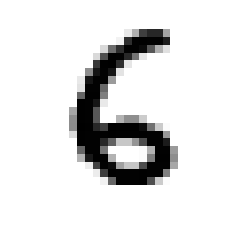

In [32]:
# Draw it
some_example = some_example.reshape(28, 28)

fig = plt.figure()
plt.imshow(some_example, cmap=plt.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [33]:
# Take a look at its class
mnist_y_train[idx]

6

<ul>
    <li>We need to reshape:
        <ul>
            <li>Our training data is in a 3D array of shape (60000, 28, 28).</li>
            <li>We change it to a 2D array of shape (60000, 28 * 28).
                <ul>
                    <li>This 'flattens' the images.</li>
                    <li>When working with images, it is often better not to do this. In a future lecture, we'll
                        build neural networks that do not require us to flatten.
                    </li>
                </ul>
            </li>
            <li>Similarlly, the test data.</li>
        </ul>
    </li>
</ul>

In [34]:
mnist_x_train = mnist_x_train.reshape((60000, 28 * 28))

mnist_x_test = mnist_x_test.reshape((10000, 28 * 28))

<ul>
    <li>We'll do a two-layer network:
        <ul>
            <li>One hidden layer with 512 neurons, using the ReLU activation function.</li>
            <li>The output layer will have 10 neurons, one per class, and 
                will use the softmax activation function.</li>
        </ul>
    </li>
    <li>The features (pixel values) are all in the same range $[0, 255]$, so we do not need to standardize
        using a <code>Normalization</code> layer.
    </li>
    <li>But it is a bad idea to feed into a neural network values that are much larger than the initial weights, so
        we will rescale to $[0, 1]$ by dividing by 255. We can do this using a <code>Rescaling</code> layer.
    </li>
</ul>

In [35]:
inputs = Input(shape=(28 * 28,))
x = Rescaling(scale=1./255)(inputs)
x = Dense(512, activation="relu")(x)
outputs = Dense(10, activation="softmax")(x)
mnist_model = Model(inputs, outputs)

mnist_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [36]:
mnist_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 784)]             0         
                                                                 
 rescaling (Rescaling)       (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               401920    
                                                                 
 dense_16 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


<ul>
    <li>Make sure you understand all the numbers above!
    </li>
</ul>

In [37]:
mnist_model.fit(mnist_x_train, mnist_y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4315 - accuracy: 0.8917
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2168 - accuracy: 0.9384
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1695 - accuracy: 0.9516
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1399 - accuracy: 0.9599
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1198 - accuracy: 0.9662
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1045 - accuracy: 0.9706
Epoch 7/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0932 - accuracy: 0.9736
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0837 - accuracy: 0.9767
Epoch 9/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0763 - accuracy: 0.9784
Epoch 10/10
1875/1875 [==============================] - 16s 8ms/step - los

In [38]:
test_loss, test_acc = mnist_model.evaluate(mnist_x_test, mnist_y_test)
test_acc

313/313 [==============================] - 2s 5ms/step - loss: 0.0850 - accuracy: 0.9752


0.9751999974250793

<ul>
    <li>Compare training accuracy and test accuracy.</li>
</ul>

<ul>
    <li>In the 1960s, 70s, 80s and to some extent 90s, the typical pipeline for a computer vision (or image processing) system was as follows:
        <ul>
            <li>There would be a module that would extract features from the images. These features would have been carefully hand-designed. They might include edges detected by some edge detection algorithm, for example. (If you are interested, look up SIFT or SURF or HOG.)</li>
            <li>Then these features would be fed into a typical learning algorithm, e.g. logistic regression.</li>
        </ul>
    </li>
    <li>Notice how different life is now &mdash; when using neural networks.
        <ul>
            <li>There's no extraction of hand-crafted features. We feed in the raw pixel values (or, lightly-processed pixel values, e.g. scaled values).</li>
            <li>It is the layers of the neural network that automatically <em>discover</em> the features, and the final layer that makes the classification.</li>
        </ul>
    </li>
    <li>As we will see, dense layers are only one possibility. Computer vision (image processing) more often also uses convolutional layers, pooling layers, batch normalization layers, and so on. We will study these soon.</li>
</ul>

<h1>Concluding Remarks</h1>
<ul>
    <li>A few decisions are constrained: number of inputs; number of output neurons; activation
        function of output neurons; and (to some extent) loss function.
    </li>
    <li>But there are numerous hyperparameters (and even more to come!)
        <ul>
            <li>Even making a good guess at them is more art than science, although this is changing.</li>
            <li>On the other hand, grid search or randomized search will make things even slower than they
                already are &mdash; and we still have to specify some sensible values for
                them to search through.
            </li>
        </ul>
    </li>
    <li>There is a considerable risk of overfitting.</li>
</ul>